In [2]:
!pip install d2l==1.0.0b0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 29.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.7 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616823 sha256=52539f2fd0047ecf5649e4d8fe2711763e923bef6b83a480bac83fc41d251c88
  Stored in directory: /root/.cache/pip/wheels/27/6d/b3/a3a6e10704795c9b9000f1ab2dc480dfe7bed42f5972806e73
Successfully built gym
  Attempting uninstal

# 3.1 Linear Regression

코드적으로는 그냥 간단한 수식 체험, 본문 내용이 훨씬 의미가 있다

vectorization for speed

In [3]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [5]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)
# two 10000-dim vectors

In [9]:
c = torch.zeros(n)
t = time.time()
for i in range(n):
  c[i] = a[i] + b[i]
print(f'{time.time() - t:.5f} sec') #Loop 시간 측정

0.10799 sec


In [10]:
t = time.time()
d = a + b
print(f'{time.time() - t:.5f} sec') #vector 시간 측정 -> 훨씬 benefit

0.00160 sec


The normal distribution(정규분포) and squared loss

정규분포 공식이야 아래는

In [11]:
def normal(x, mu, sigma):
  p = 1/math.sqrt(2*math.pi*sigma**2)
  return p*np.exp(-0.5*(x-mu)**2/sigma**2)

visualize 해보자

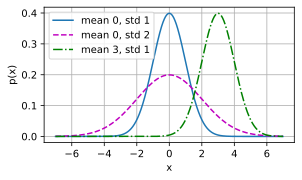

In [13]:
x = np.arange(-7, 7, 0.01)

#Mean and standard deviation pairs -> mu and sigma is mean and standard distribution
params = [(0,1), (0,2), (3,1)]
d2l.plot(x, [normal(x,mu,sigma) for mu, sigma in params], xlabel='x', ylabel='p(x)', figsize=(4.5,2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

# 3.2 Object-Oriented Design for Implementation

In [4]:
import time
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

utilities, 객체 지향 도움되라고 몇개 유틸리티 함수들

https://technote.kr/248 <- setattr 함수 사용법


In [5]:
def add_to_class(Class): #utility 1 -> 클래스 담기용
  def wrapper(obj):
    setattr(Class, obj.__name__, obj)
  return wrapper

#setattr(object, name, value)
#object에 존재하는 속성의 값을 바꾸거나, 새로운 속성을 생성하여 값을 부여한다.

작동하는거 한 번 보자!

In [6]:
class A: #create new class
  def __init__(self): 
    self.b = 1

a = A()

데코레이터는 함수에 무언가 내용을 추가하고 싶을 때 사용하는 기능입니다. 단순히 함수에 바로 내용을 추가하지 않고 데코레이터를 쓰는 이유는 다른 함수들에도 반복적으로 추가할 수 있도록 관리하기 위해서입니다. 

In [7]:
@add_to_class(A)
def do(self):
  print('Class attribute "b" is', self.b)

a.do() #a는 원래 do 가 멤버 함수로 없었는데 데코레이트로 추가 사용이 가능해짐

Class attribute "b" is 1


In [8]:
class HyperParameters: #untility 2 -> save all arguments in a class's __init__
  def save_hyperparameters(self, ignore=[]):
    raise NotImplemented #구현되지 않음을 의미

In [9]:
# Call the fully implemented HyperParameters class saved in d2l
class B(d2l.HyperParameters):
  def __init__(self, a, b, c):
    self.save_hyperparameters(ignore=['c'])
    print('self.a =', self.a, 'self.b =', self.b)
    print('There is no self.c =', not hasattr(self, 'c'))

b = B(a=1, b=2, c=3)

self.a = 1 self.b = 2
There is no self.c = True


hasattr(object, name)
object의 속성(attribute) 존재를 확인한다.
만약 argument로 넘겨준 object 에 name 의 속성이 존재하면 True, 아니면 False를 반환한다. 

In [10]:
class ProgressBoard(d2l.HyperParameters):  #utility 3 -> plot 돕기
    """The board that plots data points in animation."""
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        raise NotImplemented

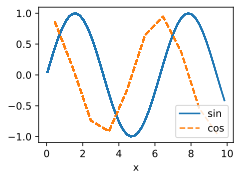

In [24]:
board = d2l.ProgressBoard('x')
for x in np.arange(0, 10, 0.1):
    board.draw(x, np.sin(x), 'sin', every_n=2)
    board.draw(x, np.cos(x), 'cos', every_n=10) #사용 예시

아래 내용이 훈련이 되는 큰 과정이라고 보면 된다.

class 1 : Model class

In [11]:
class Module(nn.Module, d2l.HyperParameters):
  def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
    super().__init__()
    self.save_hyperparameters()
    self.borad = ProgressBoard()

  def loss(self, y_hat, y):
    raise NotImplemented
  
  def forward(self, X):
    assert hasattr(self, 'net'), 'Neural network is defined'
    return self.net(X)

  def plot(self, key, value, train):
    """Plot a point in animation"""
    assert hasattr(self, 'trainer'), 'Trainer is not defined'
    self.boarad.xlabel = 'epoch'
    if train:
      x = self.trainer.train_batch_idx / self.trainer.num_train_batches
      n = self.trainer.num_train_batches / self.plot_train_per_epoch
    else:
      x = self.trainer.epoch + 1
      n = self.trainer.num_val_batches / self.plot_valid_per_epoch
    self.board.draw(x, value.to(d2l.cpu()).detach().numpy(),
                        ('train_' if train else 'val_') + key, every_n=int(n))
  
  def training_step(self, batch):
    l = self.loss(self(*batch[:-1]), batch[-1])
    self.plot('loss', l, train=True)
    return l
  
  def validation_step(self, batch):
    l = self.loss(self(*batch[:-1]), batch[-1])
    self.plot('loss', l, train=False)

  def configure_optimizers(self):
    raise NotImplemented

class 2 : Data

In [12]:
class DataModule(d2l.HyperParameters):  
    """The base class of data."""
    def __init__(self, root='../data', num_workers=4):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError

#아래 두개가 결국 내보내는거
    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

class 3 : Training

In [14]:
class Trainer(d2l.HyperParameters):
  def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
    self.save_hyperparameters()
    assert num_gpus == 0, 'No GPU support yet'

  def prepare_dat(self, data): #class 2가 input
    self.train_dataloader = data.train_dataloader()
    self.val_dataloader = data.val_dataloader()
    self.num_train_batches = len(self.train_dataloader)
    self.num_val_batches = (len(self.val_dataloader) if self.val_dataloader is not None else 0)

  def prepare_model(self, model): #class 1이 input
    model.trainer = self
    model.board.xlim = [0, self.max_epochs]
    self.model = model
  
  def fit(self, model, data): #이게 최종 key method
    self.prepare_data(data)
    self.prepare_model(model)
    self.optim = model.configure_optimizers()
    self.epoch = 0
    self.train_batch_idx = 0
    self.val_batch_idx = 0
    for self.epoch in range(self.max_epochs):
      self.fit_epoch()
  
  def fit_epoch(self):
    raise NotImplemented

# 3.3 Synthetic Regression Data